In [1]:
import numpy as np
import opendssdirect as dss
from utils.device.Inverter import Inverter
from utils.controller.AdaptiveInvController import AdaptiveInvController
from utils.controller.FixedInvController import FixedInvController
import matplotlib.pyplot as plt
from math import tan,acos
import copy
import pandas as pd
import time

%matplotlib inline

# import numpy as np
# from matplotlib.mlab import PCA
# from sklearn.decomposition import PCA

import scipy.linalg as spla


#######################################################
#######################################################
###Global variable initialization and error checking###
#######################################################
#######################################################
Sbase=1
LoadScalingFactor = 3
GenerationScalingFactor = 5
SlackBusVoltage = 1.00
NoiseMultiplyer= 1
#Set simulation analysis period - the simulation is from StartTime to EndTime
StartTime = 40600
EndTime = StartTime + 640
EndTime += 1 # creating a list, last element does not count, so we increase EndTime by 1
#Set hack parameters
TimeStepOfHack = 160
PercentHacked = np.array([0,0,0,0,0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0,0,0,0,0,0,0,0,0,0,0,0,0])

#Set initial VBP parameters for uncompromised inverters
VBP_normal=np.array([0.97, 1, 1, 1.03, 1.06])
VBP_attack=np.array([0.997, 1, 1, 1.003, 1.007])

#Set delays for each node
Delay_VBPCurveShift = (30+2*np.random.randn(31)).astype(int)
#Delay_VBPCurveShift = (10+2*np.random.randn(31)).astype(int)
lpf_meas_vector = (1+0.2*np.random.randn(31))
lpf_output_vector= (0.1+0.015*np.random.randn(31))

#Set observer voltage threshold
ThreshHold_vqvp = 0.06
adaptive_gain=800


power_factor=0.9
pf_converted=tan(acos(power_factor))
# Number_of_Inverters = 13 #even feeder is 34Bus, we only have 13 inverters


#Error checking of the global variable -- TODO: add error handling here!
if EndTime < StartTime or EndTime < 0 or StartTime < 0:
    print('Setup Simulation Times Inappropriately.')
if NoiseMultiplyer < 0:
    print('Setup Noise Multiplyer Correctly.')
    
dss.run_command('Redirect feeder/asdf.dss')
# dss.run_command('Redirect feeder/feeder34_B_NR/network_05node_3phase_radial.dss')

dss.Solution.Solve()
if not dss.Solution.Converged:
    print('Initial Solution Not Converged. Check Model for Convergence')
else:
    print('Initial Model Converged. Proceeding to Next Step.')
    #Doing this solve command is required for GridPV, that is why the monitors
    #go under a reset process
    dss.Monitors.ResetAll()
    
    #set solution Params
    #setSolutionParams(dss,'daily',1,1,'off',1000000,30000)
    dss.Solution.Mode(1)
    dss.Solution.Number(1)
    dss.Solution.StepSize(1)
    dss.Solution.ControlMode(-1)
    dss.Solution.MaxControlIterations(1000000)
    dss.Solution.MaxIterations(30000)
    #Easy process to get all names and count of loads, a trick to avoid
    #some more lines of code
    TotalLoads=dss.Loads.Count()
    AllLoadNames=dss.Loads.AllNames()
    print('OpenDSS Model Compliation Done.')

print('')
print(TotalLoads)
# dir(dss.Loads)

# (dss.Loads.AllNames())

# [x for x in dss.Circuit.AllBusNames() if 'bus' in x ]

# dss.Circuit.AllBusNames()

# dir(dss.Loads.AllNames)
print(len(dss.Loads.AllNames()))
print(dss.Loads.AllNames())

print(len(dss.Circuit.AllBusNames()))
print(dss.Circuit.AllBusNames())

print(dss.Bus.kVBase())

for k1 in range(len(dss.Circuit.AllBusNames())):
    if dss.Circuit.AllBusNames()[k1] == 'sourcebus':
        dss.Circuit.SetActiveBus(dss.Circuit.AllBusNames()[k1])
#         print(dss.Bus.kVBase())
        tempVoltage = dss.Bus.VMagAngle()
        tempVoltage = tempVoltage
    #     print(tempVoltage)
#         print(tempVoltage[::2])
#         print(tempVoltage[0]*np.sqrt(3)/1)
        
        print(dss.Circuit.AllBusNames()[k1])
        print('BASE - LN')
        print(dss.Bus.kVBase())
        print('VMAGANGLE - LN POLAR')
        print(dss.Bus.VMagAngle())
        print('puVMAGANGLE - LN POLAR')
        print(dss.Bus.puVmagAngle())
        print('VOTLAGES - LN CARTESIAN')
        print(dss.Bus.Voltages())
        print('puVOTLAGES - LN CARTESIAN')
        print(dss.Bus.PuVoltage())
        print('VLL - LL CARTESIAN')
        print(dss.Bus.VLL())
        print('puVLL - LL CARTESIAN')
        print(dss.Bus.puVLL())
        
        tempvoltage = dss.Bus.Voltages()
        
        Vab = tempvoltage[0]
        
print('~~~~~')
        
for k1 in range(len(dss.Circuit.AllBusNames())):
    dss.Circuit.SetActiveBus(dss.Circuit.AllBusNames()[k1])
    print(dss.Circuit.AllBusNames()[k1])
    print('BASE - LN')
    print(dss.Bus.kVBase())
    print('VMAGANGLE - LN POLAR')
    print(dss.Bus.VMagAngle())
    print('puVMAGANGLE - LN POLAR')
    print(dss.Bus.puVmagAngle())
    print('')

    
# dir(dss.Bus)

Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.

1959651936
0
[]
0
[]
0.0
~~~~~


In [2]:

class inverter():
    
    def __init__(self):
        
        self.max_reactive_capacity = 1
        self.reactive_capacity = 1
    
        self.reactive_power = 0
    
        self.VBP = np.array([0.97, 0.99, 1.01, 1.03])
        
        self.wlp = 2*np.pi*0.10
        
        self.Vmeas = np.zeros(86401)
        self.Vlp = np.zeros(86401)
        
        self.reactive_power = np.zeros(86401)
        
        self.Ts = 1
        
        self.hackFlag = False
        
    def set_timesteps(self, startTimeStep, endTimeStep):
        self.startTimeStep = startTimeStep
        self.endTimeStep = endTimeStep
        
    def set_nodenum(self, nodenum):
        self.nodenum = nodenum
        
    def set_nodename(self, nodename):
        self.nodename = nodename    
            
    def set_VBP(self, VBP):
        self.VBP = VBP
        
    def measure_voltage(self, timeStep, Vmeas):
        self.Vmeas[kt] = Vmeas
        
    def lowpass(self, kt):
        self.Vlp[kt] = self.Vmeas[kt-1]
#         self.Vlp[kt] = (1 - self.wlp*self.Ts)*self.Vlp[kt-1] + self.wlp*self.Ts*self.Vmeas[kt-1]
        
    def compute_reactive_power_output(self, kt, Vcomp):
        if Vcomp <= self.VBP[0]:
            self.reactive_power[kt] = -100
        elif self.VBP[0] <= Vcomp <= self.VBP[1]:
            self.reactive_power[kt] =100/(self.VBP[1] - self.VBP[0])*(Vcomp - self.VBP[1])
        elif self.VBP[1] <= Vcomp <= self.VBP[2]:
            self.reactive_power[kt] = 0
        elif self.VBP[2] <= Vcomp <= self.VBP[3]:
            self.reactive_power[kt] = 100/(self.VBP[3] - self.VBP[2])*(Vcomp - self.VBP[2])
        elif self.VBP[3] <= Vcomp:
            self.reactive_power[kt] = 100
        self.reactive_power[kt] = (2)/(1.005 - 0.995)*(Vcomp - 1)
        
    

x1 = inverter()
x1.set_VBP(np.array([0.97, 0.99, 1.01, 1.03]))
print(x1.VBP)

x1.compute_reactive_power_output(0,1.02)
print(x1.reactive_power)

# x1.measure_voltage(0,1.02)
# x1.measure_voltage(1,1.02)
# x1.measure_voltage(2,1.02)
# x1.measure_voltage(3,1.01)
# x1.measure_voltage(4,1.01)
# x1.measure_voltage(5,1.01)


print(x1.Vmeas)
print(x1.Vlp)

[0.97 0.99 1.01 1.03]
[4. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


In [3]:
#########################################################
################### RESTART OPENDSS #####################
#########################################################
dss.run_command('Redirect feeder/asdf.dss')
dss.Solution.Solve()


if dss.Solution.Converged:
    print('Initial Model Converged. Proceeding to Next Step.')
    
else:
    print('Initial Solution Not Converged. Check Model for Convergence')
    #Doing this solve command is required for GridPV, that is why the monitors
    #go under a reset process
    dss.Monitors.ResetAll()
    
    #set solution Params
    #setSolutionParams(dss,'daily',1,1,'off',1000000,30000)
    dss.Solution.Mode(1)
    dss.Solution.Number(1)
    dss.Solution.StepSize(1)
    dss.Solution.ControlMode(-1)
    dss.Solution.MaxControlIterations(1000000)
    dss.Solution.MaxIterations(30000)
    #Easy process to get all names and count of loads, a trick to avoid
    #some more lines of code
    TotalLoads=dss.Loads.Count()
    AllLoadNames=dss.Loads.AllNames()
    print('OpenDSS Model Compliation Done.')

    
#set Source Info for OpenDSS
#setSourceInfo(dss,['source'],'pu',[SlackBusVoltage]) 
dss.Vsources.PU(SlackBusVoltage)
############################################
############ INIT NODES ####################
############################################
""" 
 nodes' variable is a dictionary contains all the nodes in the grid,
 with KEY is the node's number, VALUE is a dataframe with 
 ROW is ['Voltage', 'Generation', 'P', 'Q'] - Voltage is Voltage for each timestep; 
                                              P,Q is P,Q injection at that node for that timestep.
 and 
 COLUMN is each timestep for the whole simulation. 
 nodes = {
    1: dataFrame1,
    2: dataFrame2
 }
"""

nodes = {}
features = ['Voltage', 'Generation', 'P', 'Q']

# for k1 in range(len(AllLoadNames)):
#     print(k1)
#     df = pd.DataFrame(columns=list(range(TotalTimeSteps)),index=features)
#     nodes[k1] = df
#     nodes[k1].loc['Generation'] = Generation[:,k1]
#     nodes[k1].loc['Load'] = Load[:,k1]
#     nodes[k1].loc['P'] = 0
#     nodes[k1].loc['Q'] = 0
#     nodes[k1].loc['Pinj'] = 0
#     nodes[k1].loc['Qinj'] = 0
    

    
################################################
############ INIT INVERTERS ####################
################################################
""" 
 inverters' variable is a dictionary contains all the inverters in the grid,
 with KEY is the node's number where we have inverters, VALUE is a list of inverters at that node.
 
 Each inverter has a dictionary:
     'device': Inverter_Object
     'controller: Controller_Object
     'info': contain scenario information in a dataframe (solar generation, sbar) for each timestep at that node
 }
"""

# we create inverters from node 5 to node (5+13)
offset = 5
numberofInverters = 13

# for k1 in range(len(AllLoadNames)):
#     inverters[k1] = []
#     if offset-1 < k1 < numberofInverters + offset:
#         # inverter device
#         inv = {}
#         inv['device'] = Inverter(timeList,lpf_meas=lpf_meas_vector[k1],lpf_output=lpf_output_vector[k1])
#         #controller: timeList, VBP is initial VBP, delayTimer is the delay control on VBP
#         inv['controller'] = AdaptiveInvController(timeList, 
#                                                   VBP = VBP_normal, 
#                                                   delayTimer=Delay_VBPCurveShift[k1],
#                                                   device=inv['device'], nk=adaptive_gain, threshold=ThreshHold_vqvp)
        
#         #prepare info
#         df = pd.DataFrame(columns=list(range(TotalTimeSteps)),index=features)
#         df.loc['Generation'] = Generation[:,k1]
#         df.loc['sbar'] = sbar[k1]
#         timeList = list(range(TotalTimeSteps))
#         inv['info'] = df
#         inverters[k1].append(inv)

# inverterLsist = {}

dailyTimeSteps = 86401


simStartTimeStep = 12*3600+1
simEndTimeStep = 12*3600+1 + 3600

simStartTimeStep = 6*3600+1
simEndTimeStep = 18*3600+1

simStartTimeStep = 12*3600+1
simEndTimeStep = 12*3600+1 + 1200

simStartTimeStep = 12*3600+1 - 300
simEndTimeStep = 12*3600+1 + 600

time = np.arange(simStartTimeStep,simEndTimeStep)

totalSimTimeSteps = simEndTimeStep - simStartTimeStep + 1

LoadBuses = dss.Loads.AllNames()
AllBuses = dss.Circuit.AllBusNames()

LoadBusVoltage = np.zeros((dailyTimeSteps,len(LoadBuses)))
AllBusVoltage = np.zeros((dailyTimeSteps,len(AllBuses)))


##################################################
# Set up loads
##################################################

# Nload = 25
# Load_factored = Load/1.25

# load_indexes = np.zeros((len(LoadBuses), Nload)).astype(int)
# for k1 in range(len(LoadBuses)):
    
#     load_indexes[k1,:] = np.random.randint(0, Load.shape[1], size=Nload).astype(int)
# #     load_indexes[k1,:] = load_indexes[k1,:].astype(int)
# #     print(load_indexes[k1,:])

# # print(load_indexes)
# # print(Load_factored[load_indexes[0,:],0])


##################################################
# Set up generation
##################################################

# Ngen = 15
# Generation_factored = Generation/1.5

# generation_indexes = np.zeros((len(LoadBuses), Ngen)).astype(int)
# for k1 in range(len(LoadBuses)):
    
#     generation_indexes[k1,:] = np.random.randint(0, Load.shape[1], size=Ngen).astype(int)
# #     generation_indexes[k1,:] = generation_indexes[k1,:].astype(int)
# #     print(generation_indexes[k1,:])

# # print(generation_indexes)
# # print(Generation_factored[generation_indexes[0,:],0])


##################################################
# Set up inverters
##################################################
       
inverters = []
for k1 in range(len(LoadBuses)):
    if LoadBuses[k1] == 'load_a3a' or LoadBuses[k1] == 'load_a3b' or LoadBuses[k1] == 'load_a3c':
#         for k2 in range(generation_indexes.shape[1]):
        for k2 in range(0,1):

    #         inverters[k1] = []
            tempinverter = inverter()
            tempinverter.set_timesteps(simStartTimeStep, simEndTimeStep)
            tempinverter.set_nodenum(k1)
            tempinverter.set_nodename(LoadBuses[k1])
            tempinverter.set_VBP(np.array([0.95, 0.97, 1.03, 1.05]))
            tempinverter.set_VBP(np.array([0.95, 0.99, 1.01, 1.05]))

            inverters.append(tempinverter)
            
#     if LoadBuses[k1] == 's701a' or LoadBuses[k1] == 's701b' or LoadBuses[k1] == 's701c':
# #         for k2 in range(generation_indexes.shape[1]):
#         for k2 in range(0,1):

#     #         inverters[k1] = []
#             tempinverter = inverter()
#             tempinverter.set_timesteps(simStartTimeStep, simEndTimeStep)
#             tempinverter.set_nodenum(k1)
#             tempinverter.set_nodename(LoadBuses[k1])
#             tempinverter.set_VBP(np.array([0.95, 0.97, 1.03, 1.05]))
#             tempinverter.set_VBP(np.array([0.95, 0.99, 1.01, 1.05]))

#             inverters.append(tempinverter)

    
##################################################
# ?
##################################################

LoadBuses = dss.Loads.AllNames()
AllBuses = dss.Circuit.AllBusNames()

LoadBusVoltage = np.zeros((dailyTimeSteps,len(LoadBuses)))
# LoadBusVoltage0 = np.zeros((TotalTimeSteps,len(LoadBuses)))
# LoadBusVoltage1 = np.zeros((TotalTimeSteps,len(LoadBuses)))
# LoadBusVoltage2 = np.zeros((TotalTimeSteps,len(LoadBuses)))

AllBusVoltage = np.zeros((dailyTimeSteps,len(AllBuses)))

LoadBusPinj = np.zeros((dailyTimeSteps,len(LoadBuses))) 
LoadBusQinj = np.zeros((dailyTimeSteps,len(LoadBuses)))

kWloadTS = np.zeros((dailyTimeSteps,len(LoadBuses)))
kVArloadTS = np.zeros((dailyTimeSteps,len(LoadBuses)))

kWtotalTS = np.zeros((dailyTimeSteps,len(LoadBuses)))
kVArtotalTS = np.zeros((dailyTimeSteps,len(LoadBuses)))

PloadTS = np.zeros((dailyTimeSteps,len(LoadBuses)))
PinjTS = np.zeros((dailyTimeSteps,len(LoadBuses)))
PtotalTS = np.zeros((dailyTimeSteps,len(LoadBuses)))

QloadTS = np.zeros((dailyTimeSteps,len(LoadBuses)))
QinjTS = np.zeros((dailyTimeSteps,len(LoadBuses)))
QtotalTS = np.zeros((dailyTimeSteps,len(LoadBuses)))


PloadNominal = np.zeros(len(LoadBuses))
QloadNominal = np.zeros(len(LoadBuses))
lf = np.zeros(len(LoadBuses))
for k1 in range(len(LoadBuses)):
    dss.Loads.Name(LoadBuses[k1])
    PloadNominal[k1] = dss.Loads.kW()
    QloadNominal[k1] = dss.Loads.kvar()
    lf[k1] = 1 + 0.2*(np.random.rand()-0.5)
    
print(LoadBuses)
print(PloadNominal)
print(QloadNominal)
print(lf)


#for each timestep in the simulation
# for kt in range(simStartTimeStep,simEndTimeStep):
for kt in range(simStartTimeStep,simEndTimeStep+1):
       
    if (kt - 1) % 60 == 0:
        hh = int((kt-1)/3600)
        mm = int(((kt-1) - 3600*int((kt-1)/3600))/60)
        if mm <= 9:
            print(str(hh) + '.0' + str(mm))
        else:
            print(str(hh) + '.' + str(mm))
    
#     print(kt)
    ####################################################
    ################ run the simulation ################
    ####################################################
    #for the first steps, we just initialize voltage value, no pq injection
    if kt == simStartTimeStep:
        for k1 in range(len(LoadBuses)):
            nodeName = LoadBuses[k1]
            dss.Loads.Name(nodeName)
            
#             dss.Loads.kW(1*Load_factored[kt, node])
#             dss.Loads.kvar(1*pf_converted*Load_factored[kt, node])
            
#             kWload = np.sum(Load_factored[kt,load_indexes[k1,:]])/25
#             kWloadTS[kt,k1] = kWload
#             kWtotalTS[kt,k1] = kWload
#             dss.Loads.kW(kWload)
            
            Pload = PloadNominal[k1]
            PloadTS[kt,k1] = Pload
            
            Ptotal = Pload
            PtotalTS[kt,k1] = Pload
            dss.Loads.kW(Ptotal)
            
            print(LoadBuses[k1], dss.Loads.kW())
            
#             kVArload = pf_converted*kWload
#             kVArloadTS[kt,k1] = kVArload
#             kVArtotalTS[kt,k1] = kVArload
#             dss.Loads.kvar(kVArload)
            
            Qload = QloadNominal[k1]
            QloadTS[kt,k1] = Qload
            
            Qtotal = Qload
            QtotalTS[kt,k1] = Qload
            dss.Loads.kvar(Qtotal)
            
            print(LoadBuses[k1], dss.Loads.kvar())

            
    #otherwise, we add Active Power (P) and Reactive Power (Q) which we injected at last timestep
    #to the grid at that node
    else:
        for k1 in range(len(LoadBuses)):
            nodeName = LoadBuses[k1]
            dss.Loads.Name(nodeName)
            
#             dss.Loads.kW(1*Load_factored[kt, node])
#             dss.Loads.kvar(1*pf_converted*Load_factored[kt, node])
            
#             kWload = np.sum(Load_factored[kt,load_indexes[k1,:]])/25
#             kWloadTS[kt,k1] = kWload
#             kWtotalTS[kt,k1] = kWload
#             dss.Loads.kW(kWload)

            Pload =  PloadNominal[k1] + 25*np.sin(2*np.pi*1/60*kt)
            PloadTS[kt,k1] = Pload
        
            Pinj = 0
            PinjTS[kt,k1] = Pinj
            
            Ptotal = Pload + Pinj
            PtotalTS[kt,k1] = Ptotal
            dss.Loads.kW(Ptotal)
            
#             kVArload = pf_converted*kWload
#             kVArloadTS[kt,k1] = kVArload
            
#             kVArtotal = kVArload
#             for k2 in range(len(inverters)):
#                 if inverters[k2].nodename == LoadBuses[k2]:
#                     kVArtotal = kVArtotal + inverters[k2].reactive_power[kt-1]/100*1
#             kVArtotalTS[kt,k1] = kVArtotal
#             dss.Loads.kvar(kVArtotal)
            
            Qload = QloadNominal[k1] + 15*np.sin(2*np.pi*1/60*kt)
            QloadTS[kt,k1] = Qload
            
            Qinj = 0
            for k2 in range(len(inverters)):
                if inverters[k2].nodename == LoadBuses[k1]:
#                     print(inverters[k2].nodename, LoadBuses[k2])
                    Qinj = Qinj + inverters[k2].reactive_power[kt-1]*250
            Qinj = Qinj
            QinjTS[kt,k1] = Qinj
            
            Qtotal = Qload + 1*Qinj
            QtotalTS[kt,k1] = Qtotal
            dss.Loads.kvar(Qtotal)
            
            #setLoadInfo(DSSObj, [nodeName], 'kw', [Load[kt, node] + nodes[node].at['P', kt-1]])
            #setLoadInfo(DSSObj, [nodeName], 'kvar', [pf_converted*Load[kt, node] + nodes[node].at['Q', kt-1]])

    #solve() openDSS with new values of Load
    dss.Solution.Solve()
    if not dss.Solution.Converged:
        print('Solution Not Converged at Step:', kt)
        
    dss.Monitors.SampleAll()
    #get the voltage info
    #(voltage[0]+voltage[2]+voltage[4])/(DSSCircuit.ActiveElement.NumPhases*(Loads.kV*1000/(3**0.5)))
    nodeInfo = []
    
    for k1 in range(len(LoadBuses)):
        dss.Loads.Name(LoadBuses[k1])
        voltage = dss.CktElement.VoltagesMagAng()
#         print(dss.CktElement.NodeOrder())
#         print(voltage)
#         voltagePU = (voltage[0]+voltage[2]+voltage[4])/(dss.CktElement.NumPhases()*(dss.Loads.kV()*1000/(3**0.5)))

#         LoadBusVoltage[kt,k1] = voltagePU
        
#     for k1 in range(len(AllBuses)):
# #         dss.Loads.Name(LoadBuses[k1])
#         dss.Circuit.SetActiveBus(AllBuses[k1])
#         tempVoltagePU = dss.Bus.puVmagAngle()
# #         print(tempVoltagePU)
# #         print(tempVoltage)
# #         print(tempVoltage[::2])
#         tempVoltagePU = tempVoltagePU[::2]
#         tempVoltagePU = np.sum(tempVoltagePU)/len(tempVoltagePU)
# #         print(tempVoltage)
#         LoadBusVoltage[kt,k1] = tempVoltagePU
        
    for k1 in range(len(AllBuses)):
        dss.Circuit.SetActiveBus(AllBuses[k1])
        tempVoltagePU = dss.Bus.puVmagAngle()[::2]
#         print(AllBuses[k1])
#         print(tempVoltage)
        tempVoltagePU = np.sum(tempVoltagePU)/len(tempVoltagePU)
#         tempVoltagePU = tempVoltage/(dss.Bus.kVBase()*1000)        
        AllBusVoltage[kt,k1] = tempVoltagePU
        
#         print(dss.Bus.VMagAngle())
        
#         if kt == simStartTimeStep + 20:
#             print(AllBuses[k1], tempVoltagePU)
        
#     for k1 in range(len(LoadBuses)):
        
#         inverters[k1].measure_voltage(kt,LoadBusVoltage[kt,k1])
#         inverters[k1].lowpass(kt)
    
    # Iterate through inverters
    for k1 in range(len(inverters)):
        
        AllBuses.index(inverters[k1].nodename[5:7])
        
        inverters[k1].measure_voltage(kt,AllBusVoltage[kt,AllBuses.index(inverters[k1].nodename[5:7])])
        inverters[k1].lowpass(kt)
        
        if kt >= simStartTimeStep + 10:            
            inverters[k1].compute_reactive_power_output(kt, inverters[k1].Vlp[kt])
        
#         inverters[k1].compute_reactive_power_output(kt, inverters[k1].Vlp[kt])
        
    if kt == 12*3600+1+60:
        for k1 in range(len(inverters)):
            inverters[k1].set_VBP(inverters[k1].VBP)
            if np.random.rand() <= 2:
                inverters[k1].hackFlag = True
                inverters[k1].set_VBP(np.array([0.99, 0.995, 1.005, 1.01]))


                

Initial Model Converged. Proceeding to Next Step.
[]
[]
[]
[]
11.55
11.56
11.57
11.58
11.59
12.00
12.01
12.02
12.03
12.04
12.05
12.06
12.07
12.08
12.09
12.10


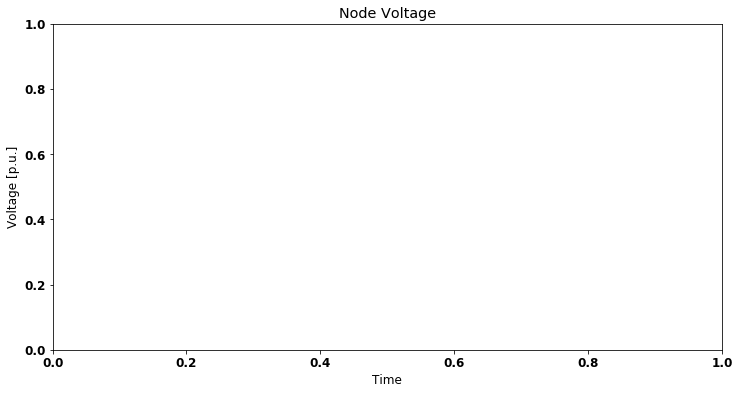

No handles with labels found to put in legend.


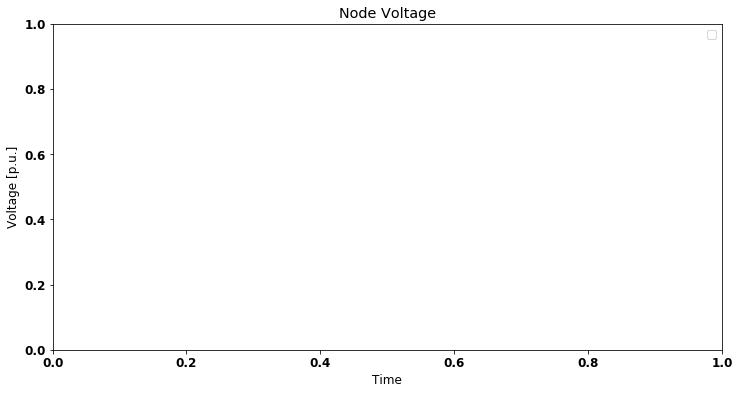

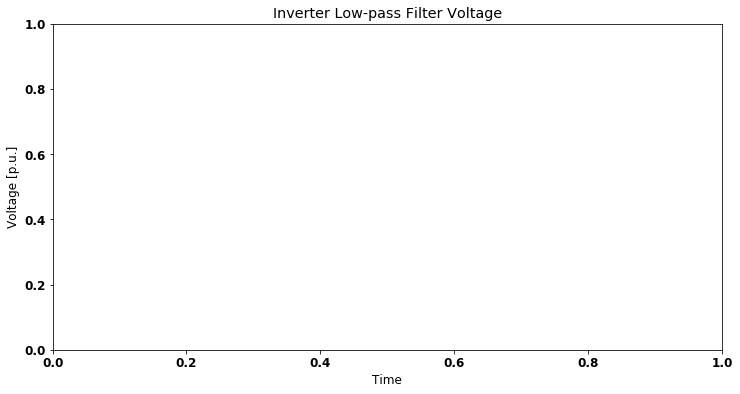

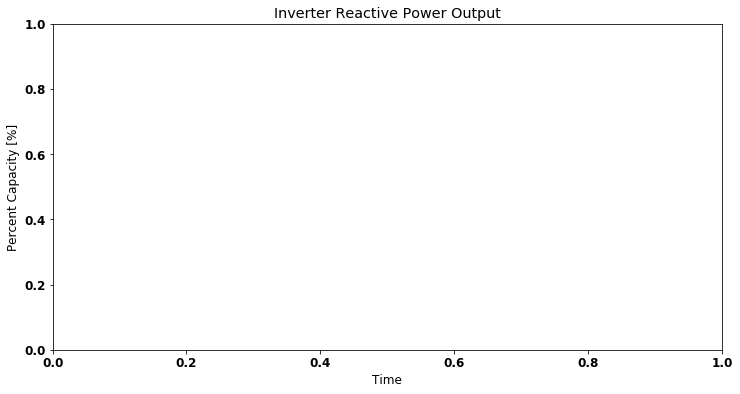

ZeroDivisionError: integer division or modulo by zero

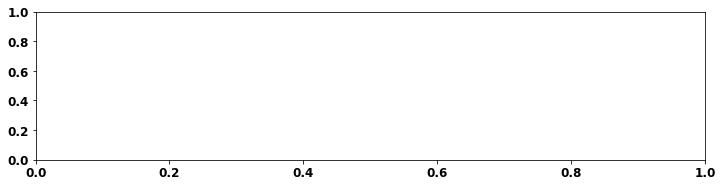

In [4]:
font = {'weight':'bold', 'size':12}

plt.rc('font', **font)

plotStartTimeStep = 12*3600 + 1
plotEndTimeStep = 12*3600 + 1 + 300

time = np.arange(plotStartTimeStep,plotEndTimeStep)

timehh = ((time-1)/3600).astype(int)
timemm = ((time-1) - 3600*timehh)/60

timeplot = timehh.astype(float) + timemm/100

fig = plt.figure(figsize=[12,6])
# for k1 in range(0,LoadBusVoltage.shape[1]):
for k1 in range(len(LoadBuses)):
#     plt.plot(time/3600,LoadBusVoltage[plotStartTimeStep:plotEndTimeStep,k1])
    plt.plot(timeplot,LoadBusVoltage[plotStartTimeStep:plotEndTimeStep,k1] - np.mean(LoadBusVoltage[plotStartTimeStep:plotEndTimeStep,k1]))
#     print(LoadBuses[k1])
plt.title('Node Voltage')
plt.xlabel('Time')
plt.ylabel('Voltage [p.u.]')
plt.show()


fig = plt.figure(figsize=[12,6])
# for k1 in range(0,LoadBusVoltage.shape[1]):
for k1 in range(len(AllBuses)):
    plt.plot(time/3600,AllBusVoltage[plotStartTimeStep:plotEndTimeStep,k1],label=AllBuses[k1])
#     print(LoadBuses[k1])
plt.title('Node Voltage')
plt.xlabel('Time')
plt.ylabel('Voltage [p.u.]')
plt.legend()
plt.show()

fig = plt.figure(figsize=[12,6])
for k1 in range(0,len(inverters)):
#     plt.plot(inverters[k1].Vmeas[plotStartTimeStep:plotEndTimeStep])
    plt.plot(time/3600,inverters[k1].Vlp[plotStartTimeStep:plotEndTimeStep])
# plt.ylim([0.85, 1.05])
plt.title('Inverter Low-pass Filter Voltage')
plt.xlabel('Time')
plt.ylabel('Voltage [p.u.]')
plt.show()

fig = plt.figure(figsize=[12,6])
for k1 in range(0,len(inverters)):
    plt.plot(time/3600,inverters[k1].reactive_power[plotStartTimeStep:plotEndTimeStep])
# plt.ylim([-100, 100])
plt.title('Inverter Reactive Power Output')
plt.xlabel('Time')
plt.ylabel('Percent Capacity [%]')
plt.show()

# fig = plt.figure(figsize=[12,6])
# plt.plot(time/3600,PloadTS[plotStartTimeStep:plotEndTimeStep,:])
# plt.plot(time/3600,QloadTS[plotStartTimeStep:plotEndTimeStep,:])
# plt.title('Load Demands')
# plt.xlabel('Time')
# plt.ylabel('Percent Capacity [%]')
# plt.show()

fig = plt.figure(figsize=[12,6])
plt.subplot(2,1,1)
plt.plot(time/3600,PloadTS[plotStartTimeStep:plotEndTimeStep,:])
plt.title('Node Active Power Demand')
# plt.xlabel('Time')
plt.ylabel('Active Power Demand [kW]')
plt.subplot(2,1,2)
plt.plot(time/3600,QloadTS[plotStartTimeStep:plotEndTimeStep,:])
plt.title('Node Reactive Power Demand')
plt.xlabel('Time')
plt.ylabel('Reactive Power Demand [kVAr]')
plt.show()

# fig = plt.figure(figsize=[12,6])
# plt.plot(time/3600,PinjTS[plotStartTimeStep:plotEndTimeStep,:])
# plt.plot(time/3600,QinjTS[plotStartTimeStep:plotEndTimeStep,:])
# plt.title('Injection')
# plt.show()

fig = plt.figure(figsize=[12,6])
plt.subplot(2,1,1)
plt.plot(time/3600,PinjTS[plotStartTimeStep:plotEndTimeStep,:])
plt.title('Node Active Power Injection')
# plt.xlabel('Time')
plt.ylabel('Active Power Injection [kW]')
plt.subplot(2,1,2)
plt.plot(time/3600,QinjTS[plotStartTimeStep:plotEndTimeStep,:])
plt.title('Node Reactive Power Injection')
plt.xlabel('Time')
plt.ylabel('Reactive Power Injection [kVAr]')
plt.show()

# fig = plt.figure(figsize=[12,6])
# plt.plot(time/3600,PtotalTS[plotStartTimeStep:plotEndTimeStep,:])
# plt.plot(time/3600,QtotalTS[plotStartTimeStep:plotEndTimeStep,:])
# plt.title('Total')
# plt.show()

fig = plt.figure(figsize=[12,6])
plt.subplot(2,1,1)
plt.plot(time/3600,PtotalTS[plotStartTimeStep:plotEndTimeStep,:])
plt.title('Node Total Active Power')
# plt.xlabel('Time')
plt.ylabel('Total Active Power [kW]')
plt.subplot(2,1,2)
plt.plot(time/3600,QtotalTS[plotStartTimeStep:plotEndTimeStep,:])
plt.title('Node Total Reactive Power')
plt.xlabel('Time')
plt.ylabel('Total Reactive Power [kVAr]')
plt.show()

# print(timeplot)


In [ ]:
dss.Circuit.SetActiveBus(AllBuses[2])
dss.Bus.Nodes()

In [ ]:
inverters[0].nodename

In [ ]:
print(AllBuses)

AllBusVoltage[simStartTimeStep,:]

In [ ]:
Zbase = ((4.8e3/np.sqrt(3))**2)/(2500e3/3)

print(Zbase)

dss.Lines.Name('line_799_701')
dss.Lines.Name()
dss.Lines.XMatrix()

Xmat = np.array(dss.Lines.XMatrix())
Xmat = Xmat*dss.Lines.Length()
Xmatpu = Xmat/Zbase

print(Xmatpu)


dss.Lines.Name('line_701_702')
dss.Lines.Name()
dss.Lines.XMatrix()

Xmat = np.array(dss.Lines.XMatrix())
Xmat = Xmat*dss.Lines.Length()

Xmatpu = Xmat/Zbase

print(Xmatpu)

x01 = 0.08
x12 = 0.00759549
x23 = 0.00596788

print(Xmat)

Xmat = np.array([[x01, x01, x01],[x01, x01+x12, x01+x12],[x01, x01+x12,x01+x12+x23]])
spla.inv(Xmat)

In [ ]:
Ns = 20

# for kt in range(12*3600+1+60,simEndTimeStep-Ns):
for kt in range(12*3600+1+60,12*3600+1+60+2):
    
    print(kt)
    
    xx = AllBusVoltage[kt:kt+Ns,1:].T
    print(xx.shape)
    
    yy = AllBusVoltage[kt+1:kt+1+Ns,1:].T
    print(yy.shape)

    xxblkdiag = spla.block_diag(xx.T,xx.T)
    for k1 in range(1,xx.shape[0]-1):
        xxblkdiag = spla.block_diag(xxblkdiag,xx.T)
    print(xxblkdiag.shape)

    yyvec = yy.T.reshape((-1,1), order='F')
    print(yyvec.shape)

    Bvec = spla.inv(xxblkdiag.T@xxblkdiag)@(xxblkdiag.T@yyvec)
#     print(Bvec)
    
    Ahat = Bvec.reshape((xx.shape[0],xx.shape[0]), order='F').T
    print(Ahat)
    
    A = spla.inv(Xmat)@Ahat
    print(A)
    
    U, s, Vh = spla.svd(A)
    print(U)
    print(s)
    print(Vh)
    
#     print(np.diag(s[[0]]))
        
    print(U[:,[0]]@np.diag(s[[0]])@Vh[[0],:])
    

In [ ]:
dir(dss.Lines.AllNames)

dss.Lines.AllNames()

In [ ]:
Zbase = ((4.8e3/np.sqrt(3))**2)/(2500e3/3)

print(Zbase)

dss.Lines.Name('line_799_701')
dss.Lines.Name()
dss.Lines.XMatrix()

Xmat = np.array(dss.Lines.XMatrix())
Xmat = Xmat*dss.Lines.Length()
Xmatpu = Xmat/Zbase

print(Xmatpu)


dss.Lines.Name('line_701_702')
dss.Lines.Name()
dss.Lines.XMatrix()

Xmat = np.array(dss.Lines.XMatrix())
Xmat = Xmat*dss.Lines.Length()

Xmatpu = Xmat/Zbase

print(Xmatpu)

x01 = 0.1
x12 = 0.00759549
x23 = 0.00596788

X = np.array([[x01, x01, x01],[x01, x01+x12, x01+x12],[x01, x01+x12,x01+x12+x23]])
spla.inv(X)

print(X)
print(spla.inv(X))

In [ ]:
dss.Loads.AllNames()
print(dss.CktElement.BusNames('load_a2b'))